# CliMA GCM simple plot example

In [124]:
# setup modules 
import numpy as np
from netCDF4 import Dataset
import iris
from scipy import signal
import iris.analysis.cartography
import fnmatch
import os
from matplotlib import animation, rc
from IPython.display import HTML

import iris.plot as iplt
import matplotlib.pyplot as plt
import iris.quickplot as qplt


## Combine files and extract data

In [125]:
# import data per variable
from glob import glob

filenames = '/central/groups/esm/lenka/VizCLIMA_data/HeldSuarez_AtmosDefault_GCM*.nc'
file_names = sorted(glob(filenames))

# this loads one or all variables as cubes with time as a new dimension
def load_variable(file_names, varname):
    lfn = len(file_names)
    simtime_cubes = iris.load(file_names)[:lfn]   
    if varname == 'all':
        len_vars = (len(iris.load(file_names)) / lfn) -1
        cubes_all = iris.cube.CubeList()
        for v_i in np.arange(len_vars):
            cubes = (iris.load(file_names)[lfn:])[lfn*v_i:lfn*(v_i+1)]
            for i,cube in enumerate(cubes):
                cube.add_aux_coord(iris.coords.AuxCoord((simtime_cubes[i]).data, "time", long_name = "simtime", units="seconds"))
            cubes_all.append(cubes.merge_cube())    
        return cubes_all        
    else:
        cubes = iris.load(file_names, varname)
        for i,cube in enumerate(cubes):
            cube.add_aux_coord(iris.coords.AuxCoord((simtime_cubes[i]).data, "time", long_name = "simtime", units="seconds"))
        return cubes.merge_cube()
    
cube_u = load_variable(file_names, 'u')
print cube_u
print cube_u.coord('time')[:]

cubes_all = load_variable(file_names, 'all')
print cubes_all
print cubes_all[5].coord('time')[:]

# note the indices for each variable (will be useful below)



u / (1)                             (time: 27; long: 73; lat: 37; rad: 31)
     Dimension coordinates:
          time                           x         -        -        -
          long                           -         x        -        -
          lat                            -         -        x        -
          rad                            -         -        -        x
DimCoord(array([  98346.31,  196690.06,  295033.8 ,  393377.56,  491721.3 ,
        590085.94,  688460.94,  786835.94,  885210.94,  983585.94,
       1081960.9 , 1180335.9 , 1278710.9 , 1377085.9 , 1475460.9 ,
       1573835.9 , 1672210.9 , 1770585.9 , 1868960.9 , 1967335.9 ,
       2065710.9 , 2164000.8 , 2262250.8 , 2360500.8 , 2458750.8 ,
       2557000.8 , 2655250.8 ], dtype=float32), standard_name='time', units=Unit('seconds'), long_name='simtime')
0: u / (1)                             (time: 27; long: 73; lat: 37; rad: 31)
1: T / (1)                             (time: 27; long: 73; lat: 37; rad: 31)

In [129]:
# coord info
lo = cubes_all[5].coord('long')[:]
la = cubes_all[5].coord('lat')[:]
ra = cubes_all[5].coord('rad')[:]
time = cubes_all[5].coord('time')[:]

lat = np.array(la.points)
lon = np.array(lo.points)
rad = np.array(ra.points)

## Zonal mean view

### 1. Time mean plots

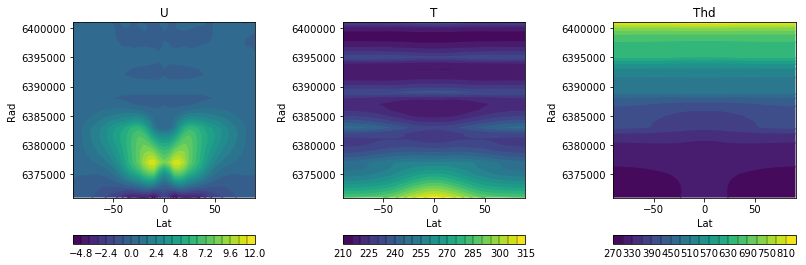

In [130]:
# temperature and zonal wind

plt.figure(figsize=(15,4))
plt.subplot(141)
cubes_all[0].transpose()
zonal_wind = (cubes_all[0]).collapsed(['time','long'], iris.analysis.MEAN)
qplt.contourf( zonal_wind ,20)

plt.subplot(142)
cubes_all[1].transpose()
air_temp = (cubes_all[1]).collapsed(['time','long'], iris.analysis.MEAN)
qplt.contourf(air_temp,20)

plt.subplot(143)
cubes_all[4].transpose()
pot_temp = (cubes_all[4]).collapsed(['time','long'], iris.analysis.MEAN)
qplt.contourf(pot_temp,20)

plt.tight_layout()


### 2. Animation

In [133]:
%%capture
%matplotlib inline

# Clean load
cubes_all = load_variable(file_names, 'all') 

# Initialise plot
cubes_all[1].transpose()
var_anim = np.transpose(cubes_all[1].collapsed(['long'], iris.analysis.MEAN).data)
rnge = 20                                   
x,y = np.meshgrid(lat,rad)
fig = plt.figure() 
plt.xlabel(r'lat')
plt.ylabel(r'rad')
init = plt.contourf(x, y, np.transpose(var_anim[0,:,:])*np.nan, rnge); plt.colorbar(init)

t = np.array(time.points)/60./60./24.

# animation function
def update(i): 
    z = var_anim[i,:,:]
    cont = plt.contourf(x, y, np.transpose(z), rnge)
    plt.title(r'day %s' % int(t[i]))    
    return cont  

# create animatoin
anim = animation.FuncAnimation(fig, update, frames = np.arange(len(t)), interval=200)

# enable inline display in the notebook
HTML(anim.to_jshtml())
rc('animation', html='jshtml')

In [136]:
# display
anim

## Horizontal plane view

In [135]:
# e.g. get upper level, say 10 km altitude
cubes_all = load_variable(file_names, 'all')
cubes_upper = cubes_all.extract(iris.Constraint(rad=6381000))

### 1. Animation

In [138]:
%%capture
%matplotlib inline

# Choose variable and its range
var_anim = (cubes_upper[0]).data # u
rnge = np.linspace(-10,30,20)

var_anim = (cubes_upper[4]).data # pot temp
rnge = np.linspace(310,340,20)

var_anim = (cubes_upper[5]).data # vort
rnge = np.linspace(-9e-6,9e-6,20)

# Initialise plot
x,y = np.meshgrid(lon,lat)
fig = plt.figure() 
plt.xlabel(r'lon')
plt.ylabel(r'lat')
init = plt.contourf(x, y, np.transpose(var_anim[0,:,:])*np.nan, rnge); plt.colorbar(init)

t = np.array(time.points)/60./60./24.

# animation function
def update(i): 
    z = var_anim[i,:,:]
    cont = plt.contourf(x, y, np.transpose(z), rnge)
    plt.title(r'day %s' % int(t[i]))    
    return cont  

# create animatoin
anim = animation.FuncAnimation(fig, update, frames = np.arange(len(t)), interval=200)

# enable inline display in the notebook
HTML(anim.to_jshtml())
rc('animation', html='jshtml')

In [139]:
# display
anim

### 2. Vorticity test
- the voticity model output is calculated in DG space, allowing for more accurate gradient calculation. As a sanity check, here we compare it to vorticity calculated more crudely from velocities projected on the interpolated grid.
- NB: ```iris.analysis.calculus``` offers a better functionality (e.g. curl funct) but needs more tinkering

In [140]:
# reload cleanly the cube with all vars and get vort, u and v
sel_time = -1

lfn = len(file_names)
simtime_cubes = iris.load(file_names)[:lfn]
u = (cubes_upper[0]).extract(iris.Constraint(time=(simtime_cubes[sel_time]).data))
v = (cubes_upper[3]).extract(iris.Constraint(time=(simtime_cubes[sel_time]).data))
vortrel = cubes_upper[5]

rng = np.linspace(-3e-6,3e-6,20)

Text(0.5,1,'v')

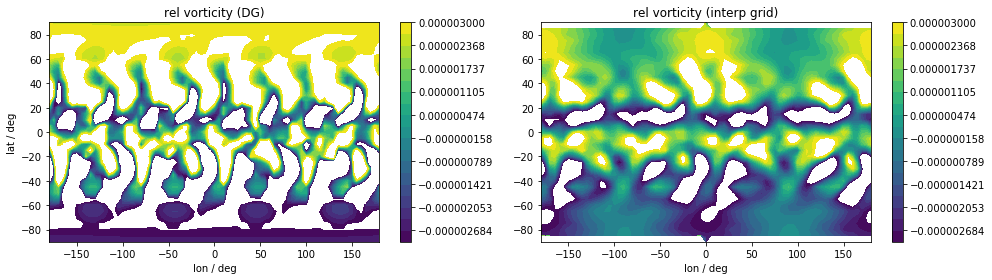

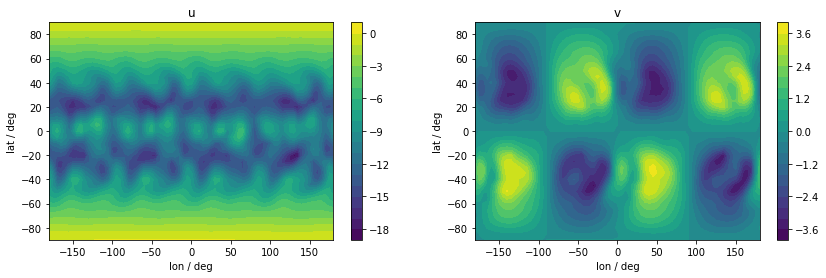

In [141]:
# plot DG vorticity
plt.figure(figsize=(14,4))
plt.subplot(121)
c = plt.contourf(lon,lat,np.transpose(np.array(vortrel.data)[sel_time,:,:]),rng)
plt.ylabel('lat / deg')
plt.xlabel('lon / deg')
plt.colorbar(c)
plt.title('rel vorticity (DG)')

# compute and plot vorticity on interpolated grid
plt.subplot(122)
dx = np.abs(lon[2]-lon[1])*np.pi/180.*np.cos(45.*np.pi/180.)*6731000.
dy = np.abs(lat[2]-lat[1])*np.pi/180.*6731000.
vortrel_test = np.gradient(np.array(v.data)/np.cos(lat*np.pi/180.),lon*np.pi/180.*6731000.,axis=0) - np.gradient(np.array(u.data),lat*np.pi/180.*6731000., axis=1)
c = plt.contourf(lon,lat,np.transpose(vortrel_test),rng)
plt.xlabel('lon / deg')
plt.colorbar(c)
plt.title('rel vorticity (interp grid)')
plt.tight_layout()

# add a plot of u and v for reference
plt.figure(figsize=(14,4))
plt.subplot(121)
rndm = cubes_upper[0]
c = plt.contourf(lon,lat,-np.transpose(np.array(rndm.data)[sel_time,:,:]),20)
plt.ylabel('lat / deg')
plt.xlabel('lon / deg')
plt.colorbar(c)
plt.title('u')
plt.subplot(122)
rndm = cubes_upper[3]
c = plt.contourf(lon,lat,-np.transpose(np.array(rndm.data)[sel_time,:,:]),20)
plt.ylabel('lat / deg')
plt.xlabel('lon / deg')
plt.colorbar(c)
plt.title('v')